<a href="https://colab.research.google.com/github/rtealwitter/dl-demos/blob/main/demo06-rnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Classifying Images using an RNN

In this demo we will use recurrent neural nets (RNNs) for a slightly non-standard application: image classification. To be clear, RNN-type architectures have been typically used for applications involving sequences (such as text, audio, time series, etc.)

For text applications, one has to somehow transform a sequence of characters into a sequence of numerical (vector) *encodings*. We will get into encodings in a later demo. 

Image data, on the other hand, is already in vector form. Let us imagine a setting where the pixels of an image are presented to the classifier in sequential form. Think of a problem where an image is being "raster-scanned", and where the classifier has to continuously updates its beliefs as new pixels come in. We will use a recurrent neural network to solve this problem.

We saw in class that standard recurrent neural networks have trouble keeping information through multiple inputs. So today, we will be using a Long Short Term Model (LSTM).

[This](https://colah.github.io/posts/2015-08-Understanding-LSTMs/) blog does an excellent job explaining how the LSTM functions. Please see their diagram below for a high level picture.

![](https://colah.github.io/posts/2015-08-Understanding-LSTMs/img/LSTM3-chain.png)

The idea is a single cell state is passed through on the top level. The first operation in each block determines what previous cell state to keep around, the second operation determines what new information to add, while the final operation decides how to combine the hidden state, input, and updated cell state for the output.

In this way, the LSTM has the opportunity to keep track of inputs that appeared long ago or overwrite them, depending on what works in the training data.

# Data loading and preparation

We will use the familiar Fashion-MNIST dataset. The following code (until building the data-loader) should be standard.

In [56]:
import torch

from torchvision import datasets
from torchvision.transforms import ToTensor
train_data = datasets.FashionMNIST(
    root = 'data',
    train = True,                         
    transform = ToTensor(), 
    download = True,            
)
test_data = datasets.FashionMNIST(
    root = 'data', 
    train = False, 
    transform = ToTensor()

)

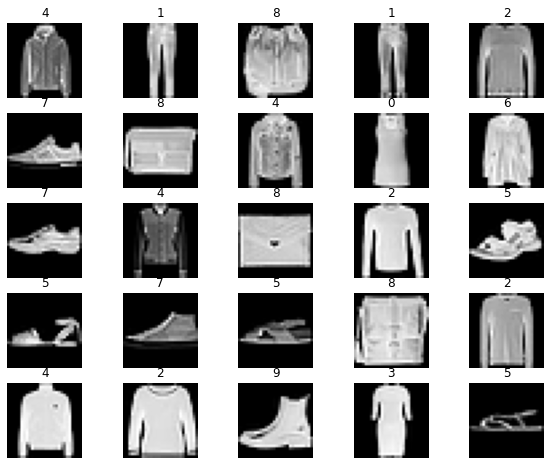

In [57]:
import matplotlib.pyplot as plt

figure = plt.figure(figsize=(10, 8))
cols, rows = 5, 5
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(train_data), size=(1,)).item()
    img, label = train_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(label)
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

In [58]:
from torch.utils.data import DataLoader
dataloaders = {
    'train' : torch.utils.data.DataLoader(train_data, 
                                          batch_size=100, 
                                          shuffle=True, 
                                          num_workers=1),
    
    'test'  : torch.utils.data.DataLoader(test_data, 
                                          batch_size=100, 
                                          shuffle=True, 
                                          num_workers=1),
}

# Setting up the RNN model

Recall that FashionMNIST images are of size $28 \times 28$. We will pretend that each row of any input image is a token (of length 28), which is presented sequentially to the RNN. Therefore there are 28 such tokens for each sequence (image).

We will assume [LSTM](https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html) recurrent units with 2 layers and hidden size 128, followed by an output linear layer that performs the classification.


In [59]:
from torch import nn
import torch.nn.functional as F

In [60]:
sequence_length = 28
input_size = 28
hidden_size = 128
num_layers = 2
num_classes = 10
batch_size = 100
num_epochs = 4
learning_rate = 0.01

The key is to set up the RNN correctly. Note that the length of the sequence is irrelevant to the model: it can process sequences of any length.

In [61]:
class RNN(nn.Module):
    
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        # Set initial hidden and cell states 
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size)
        out, hidden = self.lstm(x, (h0, c0))  # out: tensor of shape (batch_size, seq_length, hidden_size)
        
        #There are seq_length predictions, we only take the last one
        out = self.fc(out[:, -1, :])
        return out
        
        
model = RNN(input_size, hidden_size, num_layers, num_classes)
print(model)

RNN(
  (lstm): LSTM(28, 128, num_layers=2, batch_first=True)
  (fc): Linear(in_features=128, out_features=10, bias=True)
)


# Training the model

Everything looks good! Let us now train the model using the (familiar) cross-entropy loss and the Adam optimizer. We will use backpropagation-through-time (BPTT), which Pytorch automatically handles under the hood while calling `optimizer_backward()`.


In [62]:
loss_func = nn.CrossEntropyLoss()
from torch import optim
optimizer = optim.Adam(model.parameters(), lr = 0.01) 

In [63]:
# Train the model
total_step = len(dataloaders['train'])
    
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(dataloaders['train']):
        # Forward pass
        outputs = model(images.squeeze()) # remove singleton dimension
        loss = loss_func(outputs, labels)
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if (i+1) % 100 == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.2f}' 
                    .format(epoch + 1, num_epochs, i + 1, total_step, loss.item()))

Epoch [1/4], Step [100/600], Loss: 0.70
Epoch [1/4], Step [200/600], Loss: 0.62
Epoch [1/4], Step [300/600], Loss: 0.48
Epoch [1/4], Step [400/600], Loss: 0.56
Epoch [1/4], Step [500/600], Loss: 0.46
Epoch [1/4], Step [600/600], Loss: 0.45
Epoch [2/4], Step [100/600], Loss: 0.47
Epoch [2/4], Step [200/600], Loss: 0.31
Epoch [2/4], Step [300/600], Loss: 0.35
Epoch [2/4], Step [400/600], Loss: 0.39
Epoch [2/4], Step [500/600], Loss: 0.32
Epoch [2/4], Step [600/600], Loss: 0.39
Epoch [3/4], Step [100/600], Loss: 0.15
Epoch [3/4], Step [200/600], Loss: 0.33
Epoch [3/4], Step [300/600], Loss: 0.36
Epoch [3/4], Step [400/600], Loss: 0.29
Epoch [3/4], Step [500/600], Loss: 0.26
Epoch [3/4], Step [600/600], Loss: 0.20
Epoch [4/4], Step [100/600], Loss: 0.40
Epoch [4/4], Step [200/600], Loss: 0.35
Epoch [4/4], Step [300/600], Loss: 0.27
Epoch [4/4], Step [400/600], Loss: 0.32
Epoch [4/4], Step [500/600], Loss: 0.31
Epoch [4/4], Step [600/600], Loss: 0.44


# Testing

The loss looks decent enough! Let's test the model now. 

In [64]:
model.eval()
with torch.no_grad():
    correct, total = 0, 0
    for images, labels in dataloaders['test']:
        images = images.reshape(-1, sequence_length, input_size)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
print(f'Test accuracy: {100 * correct / total}%')

Test accuracy: 87.3%


In [65]:
sample = next(iter(dataloaders['test']))
imgs, lbls = sample

In [66]:
test_output = model(imgs[:10].view(-1, 28, 28))
predicted = torch.max(test_output, 1)[1].data.numpy().squeeze()
labels = lbls[:10].numpy()
print(f"Predicted label: {predicted}")
print(f"Actual label: {labels}")

Predicted label: [9 9 9 6 1 5 9 7 2 2]
Actual label: [9 9 7 6 1 9 9 7 2 2]


Not too bad! We get ~88% accuracy on FashionMNIST where the pixels are presented sequentially, which is comparable to what we got using regular dense architectures.

An advantage of RNN-based classification for images is that since RNNs work for variable-length inputs, it allows for declaring a class label even if the input is partially available (for example, if only the top one-third of the pixels were rasterized). Let's see how this would work.

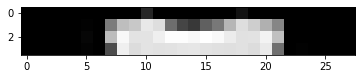

Predicted label: 0
Actual label: 0


In [67]:
idx = 32
img = imgs[idx]
num_rows = 4
img_crop = img[:,:num_rows,:]
test_output_on_crop = model(img_crop)
predicted = torch.max(test_output_on_crop, 1)[1].item()
labels = lbls[idx].item()
plt.imshow(img_crop.squeeze(),cmap='gray')
plt.show()
print(f"Predicted label: {predicted}")
print(f"Actual label: {labels}")